# Train Traffic Lights Agents

Utilise les fonctions de @Binetruy

- crée un network à partir d'un fichier .osm et des trajectoires de véhiculess
- ajoute un flux de voiture sur les routes
- personnalise un Environnement pour le RL
- integre l'environnement pour RLlib et execute la simulation


In [1]:
from flow.core.params import VehicleParams
from flow.core.params import NetParams, SumoCarFollowingParams
from flow.core.params import InitialConfig
from flow.core.params import EnvParams
from flow.core.params import SumoParams
from flow.controllers import RLController, IDMController
from flow.networks import Network
from flow.core.params import InFlows
from collections import OrderedDict
import json
import ray
from ray.rllib.agents.registry import get_agent_class
from ray.tune import run_experiments
from ray.tune.registry import register_env
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from flow.core.params import VehicleParams, SumoCarFollowingParams

## Crée le network

Specifie les noms des routes du network dont les vehicules peuvent être s'insérer

In [2]:
EDGES_DISTRIBUTION = ["-100822066", "4794817", "4783299#0", "155558218"]

créer la classe Network pour spécifier les itinéraires possibles

In [3]:
import random

class IssyOSMNetwork(Network):

    
    def get_routes_list(self):
        return list(self.specify_routes({}).keys())

    def get_random_route(self):
        return random.choice(self.get_routes_list())

    def specify_routes(self, net_params):
        return {
            "-100822066": [ #N
                "-100822066",
                "-352962858#1",
                "-352962858#0",
                "-4786940#1",
                 "-4786940#0",
            ],
            
            "4794817" : [ #Loop
                "4794817",
                "4786972#0",
                "4786972#1",
                "4786972#2",
                "4786965#1",
                "4786965#2",
                "4786965#3",
                "4795729",
                "-352962858#1",
                "4795742#0",
                "4795742#1",
                "4786965#3",
                "4786965#4",
                "4786965#5",
            ],
            
            "4783299#0": [    #E
                "4783299#0",
                "4783299#1",
                "4783299#2",
                "4783299#3",
                "4783299#4",
                "4783299#5",
                "4783299#6",
                "4786940#0",
                "4786940#1",
                "352962858#0",
                "352962858#1",
                "100822066",
            ],
            
            "155558218": [
                "155558218",
                "4786940#1",
                "352962858#0",
                "352962858#1",
                "100822066",
            ],     
        }

## Ajoute les flux de voiture

`IDMController` : The Intelligent Driver Model is a car-following model specifying vehicle dynamics by a differential equation for acceleration $\dot{v}$.

`RLController` : a trainable autuonomous vehicle whose actions are dictated by an RL agent. 

In [4]:
n_veh    = 12
vehicles = VehicleParams()
vehicles.add("human",acceleration_controller=(IDMController, {}), num_vehicles=n_veh, color='red')
vehicles.add("flow",acceleration_controller=(IDMController, {}), num_vehicles=n_veh, color='white')

- `vehs_per_hour`: nombre de vehicule par heure, uniformément espacés. Par exemple, comme il y a $60 \times 60 = 3600$ secondes dans une heure, le parametre $\frac{3600}{5}=720$ va faire rentrer des vehicules dans le network toutes les $5$ secondes.

- `probability`: c'est la probabilité qu'un véhicule entre dans le network toutes les secondes. Par exemple, si on la fixe à $0.2$, alors chaque seconde de la simulation un véhicule aura $\frac{1}{5}$ chance d'entrer dans le network

- `period`: C'est le temps en secondes entre 2 véhicules qui sont insérés. Par exemple, le fixer à $5$ ferait rentrer des véhicules dans le network toutes les $5$ secondes (ce qui équivaut à mettre `vehs_per_hour` à $720$).

<font color='red'>
$\rightarrow$ Exactement 1 seul de ces 3 paramètres doit être configurer !
</font>

In [5]:
inflow = InFlows()
for edge in EDGES_DISTRIBUTION:
    inflow.add(veh_type = "flow", edge = edge, probability = 0.1, depart_speed = 7)

## Personnalise un Environnement pour le RL

plus de méthodes sur : http://berkeleyflow.readthedocs.io/en/latest/

In [6]:
from IssyEnv import IssyEnv1

## Lance une simulation avec Training RLlib

Pour qu'un environnement puisse être entrainé, l'environnement doit être accessible via l'importation à partir de flow.envs. 


<font color='red'>
Copier l'environnement créé dans un fichier .py et on importe l'environnement dans `flow.envs.__init__.py`.
Mettre le chemin absolu du fichier .osm .
</font> 

In [7]:
# possibles actions
action_spec = OrderedDict({ "30677963": [ "GGGGrrrGGGG", "rrrrGGGrrrr"],
                            "30763263": ["GGGGGGGGGG",  "rrrrrrrrrr"],
                            "30677810": [ "GGrr", "rrGG"]})

In [8]:
horizon  = 500
SIM_STEP = 0.2
rollouts = 10
n_cpus   = 2
discount_rate = 0.999

In [9]:
# SUMO PARAM
sumo_params = SumoParams(sim_step=SIM_STEP, emission_path='emission', render=False, restart_instance=True, print_warnings=False, no_step_log=False)

# ENVIRONMENT PARAM
ADDITIONAL_ENV_PARAMS = {"beta": n_veh, "action_spec": action_spec, "algorithm": "DQN", "tl_constraint_min": 100,  "tl_constraint_max": 600, "sim_step": SIM_STEP}
env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS, horizon=horizon, warmup_steps=1)

# NETWORK PARAM
path_file  = '/home/julien/projet_CIL4SYS/NOTEBOOKS/issy.osm'
net_params = NetParams(inflows=inflow, osm_path=path_file) 

# NETWORK
network = IssyOSMNetwork

# INITIAL CONFIG
initial_config = InitialConfig(spacing="uniform",edges_distribution=EDGES_DISTRIBUTION)


flow_params = dict( exp_tag   = "ISSY_traffic", 
                    env_name  = IssyEnv1,  
                    network   = IssyOSMNetwork,
                    simulator = 'traci',
                    sim       = sumo_params,
                    env       = env_params,
                    net       = net_params,
                    veh       = vehicles,
                    initial   = initial_config)

# Setup RLlib library

Configures RLlib DQN algorithm to be used to train the RL model.

In [10]:
def setup_DQN_exp():

    alg_run   = 'DQN'
    agent_cls = get_agent_class(alg_run)
    config    = agent_cls._default_config.copy()
    config['num_workers']      = n_cpus
    config['train_batch_size'] = horizon * rollouts
    config['gamma']            = discount_rate
    config['clip_actions']     = False  # FIXME(ev) temporary ray bug
    config['horizon']          = horizon
    config["hiddens"]          = [256]
    config['model'].update({'fcnet_hiddens': [32, 32]})

    # save the flow params for replay
    flow_json = json.dumps(flow_params, cls=FlowParamsEncoder, sort_keys=True, indent=4)
    config['env_config']['flow_params'] = flow_json
    config['env_config']['run'] = alg_run

    create_env, gym_name = make_create_env(params=flow_params, version=0)

    # Register as rllib env
    register_env(gym_name, create_env)
    
    return alg_run, gym_name, config

Configures RLlib PPO algorithm to be used to train the RL model.

See: https://ray.readthedocs.io/en/latest/rllib-algorithms.html#proximal-policy-optimization-ppo

In [11]:
def setup_PPO_exp():

    alg_run   = 'PPO'
    agent_cls = get_agent_class(alg_run)
    config    = agent_cls._default_config.copy()
    config['num_workers']      = n_cpus
    config['train_batch_size'] = horizon * rollouts
    config['gamma']            = discount_rate
    config['use_gae']          = True
    config['lambda']           = 0.97
    config['kl_target']        = 0.02
    config['num_sgd_iter']     = 10
    config['clip_actions']     = False  # FIXME(ev) temporary ray bug
    config['horizon']          = horizon
    config['model'].update({'fcnet_hiddens': [32, 32]})

    # save the flow params for replay
    flow_json = json.dumps(flow_params,cls=FlowParamsEncoder,sort_keys=True,indent=4)
    config['env_config']['flow_params'] = flow_json
    config['env_config']['run'] = alg_run

    create_env, gym_name = make_create_env(params=flow_params,version=0)

    # Register as rllib env
    register_env(gym_name, create_env)
    
    return alg_run, gym_name, config

# Run Experiment

In [12]:
alg_run, gym_name, config = setup_DQN_exp()

ray.init(num_cpus=n_cpus + 1)

2020-04-23 20:51:57,608	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-04-23_20-51-57_607708_4167/logs.
2020-04-23 20:51:57,730	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:43243 to respond...
2020-04-23 20:51:57,847	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:18651 to respond...
2020-04-23 20:51:57,852	INFO services.py:809 -- Starting Redis shard with 2.09 GB max memory.
2020-04-23 20:51:57,965	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-04-23_20-51-57_607708_4167/logs.
2020-04-23 20:51:57,973	INFO services.py:1475 -- Starting the Plasma object store with 3.14 GB memory using /dev/shm.


{'node_ip_address': '10.0.2.15',
 'redis_address': '10.0.2.15:43243',
 'object_store_address': '/tmp/ray/session_2020-04-23_20-51-57_607708_4167/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-23_20-51-57_607708_4167/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-04-23_20-51-57_607708_4167'}

In [13]:
exp_tag = {"run": alg_run,
           "env": gym_name,
           "config": {**config},
           "checkpoint_freq": 2,
           "checkpoint_at_end": True,
           "max_failures": 10,
           "stop": {"training_iteration": 4}}


trials = run_experiments({flow_params["exp_tag"]: exp_tag})

2020-04-23 20:51:58,959	INFO trial_runner.py:174 -- Starting a new experiment.
2020-04-23 20:51:59,087	WARNING signature.py:108 -- The function with_updates has a **kwargs argument, which is currently not supported.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs
Memory usage on this node: 2.3/10.5 GB

_________________ STEP i ___________________________


2020-04-23 20:51:59,312	ERROR log_sync.py:34 -- Log sync requires cluster to be setup with `ray up`.
2020-04-23 20:51:59,562	WARNING util.py:145 -- The `start_trial` operation took 0.5327248573303223 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/3 CPUs, 0/0 GPUs
Memory usage on this node: 2.4/10.5 GB
Result logdir: /home/julien/ray_results/ISSY_traffic
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - DQN_IssyEnv1-v0_0:	RUNNING

_________________ STEP i ___________________________
(pid=4203) Warning: Discarding unknown compound 'cycleway.opposite' in type 'cycleway.opposite|highway.residential' (first occurence for edge '4786965#0').
(pid=4203) Warning: Discarding unknown compound 'cycleway.opposite_track' in type 'cycleway.opposite_track|highway.residential' (first occurence for edge '4786972#0').
(pid=4203) Warning: Discarding unknown compound 'cycleway.opposite' in type 'cycleway.opposite|highway.living_street' (first occurence for edge '4795758').
(pid=4203) Warning: Discarding unknown compound 'cycleway.lane' in type 'cycleway.lane|highway.secondary' (first occurence for edge '100822066').
(pid=4203) Warning: Removed a road without junctions: -2154

(pid=4264) 2020-04-23 20:52:18,400	INFO rollout_worker.py:319 -- Creating policy evaluation worker 2 on CPU (please ignore any CUDA init errors)
(pid=4264) 2020-04-23 20:52:18.427066: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2
(pid=4264) WARNING:tensorflow:VARIABLES collection name is deprecated, please use GLOBAL_VARIABLES instead; VARIABLES will be removed after 2017-03-02.
(pid=4264) WARNING:tensorflow:VARIABLES collection name is deprecated, please use GLOBAL_VARIABLES instead; VARIABLES will be removed after 2017-03-02.
(pid=4204) 2020-04-23 20:52:20,927	INFO rollout_worker.py:451 -- Generating sample batch of size 4
(pid=4204) Warning: Discarding unknown compound 'cycleway.opposite' in type 'cycleway.opposite|highway.residential' (first occurence for edge '4786965#0').
(pid=4204) Warning: Discarding unknown compound 'cycleway.opposite_track' in type 'cycleway.oppos

(pid=4204) Warning: Discarding unknown compound 'cycleway.opposite' in type 'cycleway.opposite|highway.residential' (first occurence for edge '4786965#0').
(pid=4204) Warning: Discarding unknown compound 'cycleway.opposite_track' in type 'cycleway.opposite_track|highway.residential' (first occurence for edge '4786972#0').
(pid=4204) Warning: Discarding unknown compound 'cycleway.opposite' in type 'cycleway.opposite|highway.living_street' (first occurence for edge '4795758').
(pid=4204) Warning: Discarding unknown compound 'cycleway.lane' in type 'cycleway.lane|highway.secondary' (first occurence for edge '100822066').
(pid=4264) Warning: Discarding unknown compound 'cycleway.opposite' in type 'cycleway.opposite|highway.residential' (first occurence for edge '4786965#0').
(pid=4264) Warning: Discarding unknown compound 'cycleway.opposite_track' in type 'cycleway.opposite_track|highway.residential' (first occurence for edge '4786972#0').
(pid=4264) Warning: Discarding unknown compound 'c

(pid=4203) 2020-04-23 20:53:04,635	INFO rollout_worker.py:597 -- Training output:
(pid=4203) 
(pid=4203) { 'default_policy': { 'learner_stats': { 'cur_lr': 0.0005000000237487257,
(pid=4203)                                          'max_q': 0.9569993,
(pid=4203)                                          'mean_q': -0.14834747,
(pid=4203)                                          'mean_td_error': -1.7583637,
(pid=4203)                                          'min_q': -1.2787359,
(pid=4203)                                          'model': {}},
(pid=4203)                       'td_error': np.ndarray((5000,), dtype=float32, min=-4.503, max=0.292, mean=-1.758)}}
(pid=4203) 
(pid=4204) Warning: Discarding unknown compound 'cycleway.opposite' in type 'cycleway.opposite|highway.residential' (first occurence for edge '4786965#0').
(pid=4204) Warning: Discarding unknown compound 'cycleway.opposite_track' in type 'cycleway.opposite_track|highway.residential' (first occurence for edge '4786972#0').


Result for DQN_IssyEnv1-v0_0:
  custom_metrics: {}
  date: 2020-04-23_21-04-26
  done: false
  episode_len_mean: 473.0
  episode_reward_max: 4547.953000000001
  episode_reward_mean: 2221.4471666666673
  episode_reward_min: 644.8160000000008
  episodes_this_iter: 2
  episodes_total: 6
  experiment_id: 411ce0e97e554e2e81cde4fbc27d507a
  hostname: julien-Ubuntu
  info:
    grad_time_ms: 1257.045
    learner:
      default_policy:
        cur_lr: 0.0005000000237487257
        max_q: 20.929903030395508
        mean_q: 15.082738876342773
        mean_td_error: 0.3573797047138214
        min_q: 3.047483444213867
        model: {}
    max_exploration: 0.804
    min_exploration: 0.804
    num_steps_sampled: 3000
    num_steps_trained: 1250000
    num_target_updates: 5
    opt_peak_throughput: 3977.582
    opt_samples: 5000.0
    replay_time_ms: 1049.202
    sample_time_ms: 577.45
    update_time_ms: 12.32
  iterations_since_restore: 3
  node_ip: 10.0.2.15
  num_healthy_workers: 2
  off_policy_e

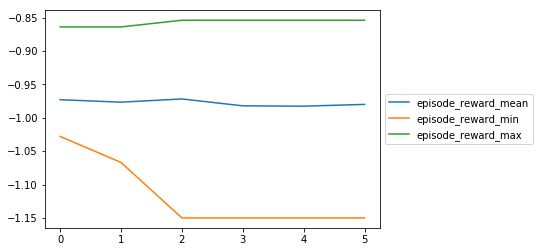

In [14]:
%run ../visualisation/plot_ray_results.py ~/ray_results/ISSY_traffic/DQN_IssyEnv1-v0_0_2020-04-09_14-19-28ex9mlxie/progress.csv episode_reward_mean episode_reward_min episode_reward_max

In [15]:
gym_name

'IssyEnv1-v0'